In [1]:
import numpy as np
from pyember.transport.diffusion import DiffusionSystem, BoundaryCondition
from pyember.core.grid import OneDimGrid, GridConfig
from typing import List, Tuple
from pyember.solvers.integrator import (
    ODESystem, BaseIntegrator, TridiagonalSystem, TridiagonalIntegrator
)
from pyember.solvers.integrator import TridiagonalIntegrator

In [ ]:
L = 1.0
N = 101
grid = OneDimGrid()
grid.setOptions(GridConfig())
grid.x = np.linspace(0, 1, N)
grid.setSize(N)
grid.dampVal = np.ones_like(grid.x)
grid.updateValues()

# Create system
system = DiffusionSystem(grid)
system.set_boundary_conditions(
    leftBC=BoundaryCondition.FixedValue,
    rightBC=BoundaryCondition.FixedValue
)

# Set properties
D = np.ones(N)
rho = np.ones(N)
system.set_properties(D, rho)

# Create integrator
integrator = TridiagonalIntegrator(system)

# Initial condition (Gaussian)
x = grid.x
sigma = 0.1
y0 = np.exp(-(x - L/2)**2 / (2*sigma**2))
integrator.set_y0(y0)

# Integrate with smaller timesteps
t0 = 0.0  
dt = 0.00001  # Timestep
tf = 0.01

integrator.initialize(t0, dt)
assert not np.any(np.isnan(integrator.y))  # Check after initialization

nsteps = int(tf/dt)
ys = []
for _ in range(nsteps):
    integrator.step()
    # Check solution remains valid
    assert not np.any(np.isnan(integrator.y))
    assert not np.any(np.isinf(integrator.y))
    
    ys.append(integrator.y.copy())
    #assert np.all(integrator.y >= 0)  # Physical constraint
    
y = integrator.get_y()

# Check solution properties
# 1. Zero gradient at right boundary
left_flux = (y[1] - y[0]) / (x[1] - x[0])
right_flux = (y[-1] - y[-2]) / (x[-1] - x[-2])
print(f"Left flux: {left_flux}")
print(f"Right flux: {right_flux}")

print(f"Left most values - y[0]: {y[0]}, y0[0]: {y0[0]}")
print(f"Right most values - y[-1]: {y[-1]}, y0[-1]: {y0[-1]}")

# # 3. Solution remains bounded
# assert np.all(y <= np.max(y0))
# # assert abs(right_flux) < 1e-3  # Zero gradient at right

# # 2. Fixed value at left boundary
# assert abs(y[0] - y0[0]) < 1e-10



In [ ]:
import matplotlib.pyplot as plt

plt.plot(x, y0, label='Initial condition', linestyle='--')
for i in np.linspace(0, nsteps-1, 30).astype(int):
    plt.plot(x, ys[i], label=f't={i*dt:.4f}')
plt.xlabel('x')
plt.ylabel('y')
# plt.legend()
plt.show()

In [14]:
class DecaySystem(TridiagonalSystem):
    """Test system with known analytical solution combining decay and diffusion"""
    
    def __init__(self):
        super().__init__()
        self.k = -2.0  # Decay rate
        self.D = 1.0  # Diffusion coefficient
        self.dx = 1/50  # Grid spacing
        
    def get_rhs(self, t: float, y: np.ndarray) -> np.ndarray:
        """RHS term (source/sink)"""
        return np.zeros_like(y)  # No additional source terms
        
    def get_coefficients(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Return coefficients for tridiagonal system"""
        N = len(self.y) if hasattr(self, 'y') else 50
        
        # Diffusion terms
        D_dx2 = self.D / (self.dx * self.dx)
        
        # Setup tridiagonal system
        a = D_dx2 * np.ones(N)  # Lower diagonal: D/(dx^2)
        b = (self.k - 2*D_dx2) * np.ones(N)  # Main diagonal: k - 2D/(dx^2)
        c = D_dx2 * np.ones(N)  # Upper diagonal: D/(dx^2)
        
        # Boundary conditions (zero gradient)
        a[0] = 0.0
        c[-1] = 0.0
        
        return a, b, c

In [ ]:
# Setup system
system = DecaySystem()
L = 1.0  # Domain length
t0 = 0.0
dt = 0.0001  # Small timestep for stability
config = {'t0': t0, 'dt': dt}

integrator = TridiagonalIntegrator(system, config)

# Create proper spatial grid
N = 50
x = np.linspace(0, L, N)

# Initial condition: Gaussian pulse
sigma = 0.1
mu = L/2
y0 = np.exp(-(x - mu)**2 / (2*sigma**2))
integrator.set_y0(y0)

# Initialize and integrate
tf = 0.1  # Reduced final time to see evolution better
integrator.initialize(t0, dt)

# Time integration
while integrator.t < tf:
    integrator.step()

# Get analytical solution for diffusion-decay equation
def analytical_solution(x, t, D, k, sigma, mu):
    """Analytical solution for diffusion-decay equation with Gaussian initial condition"""
    sigma_t = np.sqrt(sigma**2 + 2*D*t)
    return (sigma/sigma_t) * np.exp(k*t) * np.exp(-(x - mu)**2 / (2*sigma_t**2))

# Plot results
y_final = integrator.get_y()
y_exact = analytical_solution(x, tf, system.D, system.k, sigma, mu)

plt.figure(figsize=(10, 6))
plt.plot(range(N), y0, 'k--', label='Initial')
plt.plot(range(N), y_exact, '-', label='Analytical')
plt.plot(range(N), y_final, ':', label='Numerical')
plt.xlabel('Index')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(y_exact, label='Analytical')
plt.plot(y_final, label='Numerical', linestyle='--')
plt.xlabel('Index')
plt.ylabel('y')
plt.legend()
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyember.solvers.diffusion_flame import DiffusionFlame
from pyember.utils.visualization import FlameVisualizer
import cantera as ct
from tqdm import tqdm

In [ ]:
# Create configuration
config = {
    'mechanism': 'gri30.yaml',
    'fuel': 'CH4:1',
    'oxidizer': 'O2:1, N2:3.76',
    'pressure': ct.one_atm,
    'T_fuel': 300.0,
    'T_oxidizer': 600.0,
    'strain_rate': 100.0,  # 1/s
    'center_width': 0.000,
    'slope_width':0.000,
    'grid': {
        'x_min': -0.02,
        'x_max': 0.02,  # 2 cm domain
        'n_points': 100,
        'alpha': 0  # Planar
    }
}


# Create solver
flame = DiffusionFlame(config)

visualizer = FlameVisualizer(flame)


fuel_idx = flame.gas.species_index('CH4')
ox_idx = flame.gas.species_index('O2')
h2o_idx = flame.gas.species_index('H2O')
N2_idx = flame.gas.species_index('N2')
visualizer.save_state()
ts = visualizer.history['t']
Ts = visualizer.history['T']
Ys = visualizer.history['Y']
Vs = visualizer.history['V']
visualizer.plot_current_state()

In [ ]:
# Time stepping
dt = 1e-5
for i in tqdm(range(1000), desc='Time stepping'):
    flame.step(dt)
    T, Y, U = flame.get_solution()
    visualizer.save_state()

ts = visualizer.history['t']
Ts = visualizer.history['T']
Ys = visualizer.history['Y']
Vs = visualizer.history['V']

In [ ]:
# visualizer.create_animation(species_names=['CH4', 'O2', 'H2O'],interval=10)
# visualizer.save_animation('flameII.mp4',fps=10)

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=100)
time_steps_2_plot = np.linspace(0, len(ts)-1, 10, dtype=int)
for i in time_steps_2_plot:
    plt.plot(flame.grid.x, Ts[i], label=f't={ts[i]:.4f}')
plt.xlabel('Position [m]')
plt.ylabel('Temperature [K]')
plt.legend()

plt.title('Temperature profile Evolution')
plt.show()


In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=100)
time_steps_2_plot = np.linspace(0, len(ts)-1, 10, dtype=int)
for i in time_steps_2_plot:
    if i == time_steps_2_plot[-1]:
        plt.plot(flame.grid.x, Ys[i][fuel_idx], label=f'CH4, t={ts[i]:.4f}', linestyle='-', color='red')
        plt.plot(flame.grid.x, Ys[i][ox_idx], label=f'O2, t={ts[i]:.4f}', linestyle='-', color='blue')
        plt.plot(flame.grid.x, Ys[i][N2_idx], label=f'N2, t={ts[i]:.4f}', linestyle='-', color='green')
    else:
        plt.plot(flame.grid.x, Ys[i][fuel_idx], label=f'H2, t={ts[i]:.4f}', linestyle='--')
        plt.plot(flame.grid.x, Ys[i][ox_idx], label=f'O2, t={ts[i]:.4f}', linestyle='-.')
        plt.plot(flame.grid.x, Ys[i][N2_idx], label=f'N2, t={ts[i]:.4f}', linestyle=':')
    
plt.xlabel('Position [m]')
plt.ylabel('Mass Fraction')
plt.title('CH4, N2 and O2 profile Evolution')

# plt.legend()
plt.savefig('CH4_N2_O2_profile.png')

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=100)
time_steps_2_plot = np.linspace(0, len(ts)-1, 10, dtype=int)
for i in time_steps_2_plot:
    #plt.plot(flame.grid.x, Ys[i][fuel_idx], label=f'H2, t={ts[i]:.4f}')
    plt.plot(flame.grid.x, Ys[i][ox_idx], label=f'O2, t={ts[i]:.4f}')
    # plt.plot(flame.grid.x, Ys[i][h2o_idx], label=f'H2O, t={ts[i]:.4f}')
    
plt.xlabel('Position [m]')
plt.ylabel('Mass Fraction')
plt.title('O2 profile Evolution')

plt.legend()

fig = plt.figure(figsize=(8, 6), dpi=100)
time_steps_2_plot = np.linspace(0, len(ts)-1, 10, dtype=int)
for i in time_steps_2_plot:
    #plt.plot(flame.grid.x, Ys[i][fuel_idx], label=f'H2, t={ts[i]:.4f}')
    #plt.plot(flame.grid.x, Ys[i][ox_idx], label=f'O2, t={ts[i]:.4f}')
    plt.plot(flame.grid.x, Vs[i], label=f'V t={ts[i]:.4f}')
    
    
plt.xlabel('Position [m]')
plt.ylabel('Velocity [m/s]')
plt.title('Velocity profile Evolution')
plt.legend()


In [1]:
from pyember.transport.diffusion import DiffusionSystem, BoundaryCondition
from pyember.core.grid import OneDimGrid, GridConfig
from pyember.solvers.integrator import TridiagonalIntegrator
from pyember.transport.convection import (
    ConvectionSystemSplit, ConvectionConfig, ContinuityBoundaryCondition, ConvectionSystemY, ConvectionSystemUTW)
import cantera as ct
import numpy as np

In [2]:
# Create configuration
config = {
    'mechanism': 'gri30.yaml',
    'fuel': 'H2:1',
    'oxidizer': 'O2:1, N2:3.76',
    'pressure': ct.one_atm,
    'T_fuel': 300.0,
    'T_oxidizer': 300.0,
    'strain_rate': 100.0,  # 1/s
    'grid': {
        'x_min': 0.0,
        'x_max': 0.02,  # 2 cm domain
        'n_points': 100,
        'alpha': 0  # Planar
    }
}

In [27]:

# Initialize Cantera objects
gas = ct.Solution(config['mechanism'])
n_species = gas.n_species

# Initialize grid
grid_config = GridConfig(**config.get('grid', {}))
grid = OneDimGrid(grid_config)

# Initialize solution arrays
T = np.zeros(grid.x.shape)  # Temperature
Y = np.zeros((n_species, len(grid.x)))  # Mass fractions
U = np.zeros_like(T)  # Velocity/strain
rho = np.zeros_like(T)  # Density
cp = np.zeros_like(T)  # Specific heat
D = np.zeros((n_species, len(grid.x)))  # Diffusion coefficients
k = np.zeros_like(T)  # Thermal conductivity

# Initialize diffusion systems
T_system = DiffusionSystem(grid)  # Temperature
Y_systems = []  # Species mass fractions
for k in range(n_species):
    Y_systems.append(DiffusionSystem(grid))
    
# Initialize integrators
T_integrator = TridiagonalIntegrator(T_system)
Y_integrators = []
for system in Y_systems:
    Y_integrators.append(TridiagonalIntegrator(system))
    
# Initialize convection system
conv_config = ConvectionConfig(
    integrator_rel_tol=1e-8,
    integrator_abs_tol_species=1e-8,
    integrator_abs_tol_momentum=1e-8,
    integrator_abs_tol_energy=1e-8
)
convection = ConvectionSystemSplit()
convection.set_gas(gas)

# Set strain rate
strain_rate = config.get('strain_rate', 100.0)  # Default 100 1/s
strain_rate_deriv = 0.0  # Time derivative of strain rate

# Time tracking
t = 0.0

In [36]:
T_fuel = config['T_fuel']
T_oxidizer = config['T_oxidizer']
x = grid.x

# Create temperature profile with smooth transition
center = 0.5 * (x[0] + x[-1])
width = 0.2 * (x[-1] - x[0])
T = T_fuel + 0.5*(T_oxidizer - T_fuel)*(1 + np.tanh((x - center)/width))

# Set up species profiles
gas.TPX = T_fuel, config['pressure'], config['fuel']
Y_fuel = gas.Y

gas.TPX = T_oxidizer, config['pressure'], config['oxidizer']
Y_oxidizer = gas.Y

# Initialize mass fractions with smooth transition
for k in range(n_species):
    Y[k] = Y_fuel[k] + 0.5*(Y_oxidizer[k] - Y_fuel[k])*(1 + np.tanh((x - center)/width))
    
# Initialize velocity field
U = strain_rate * (x - center)
    
# Initialize convection system
state = np.zeros(shape = ((3 + n_species), len(x)))
# convection.resize(len(x), n_species, state)

# # Set convection boundary conditions
# convection.utw_system.set_boundary_conditions(
#     left_bc=BoundaryCondition.FixedValue,
#     right_bc=BoundaryCondition.FixedValue,
#     continuity_bc=ContinuityBoundaryCondition.Zero,
#     j_cont_bc=len(x)//2  # Stagnation point at center
# )

In [ ]:
# plt.plot(flame.grid.x, flame.Y[13, :])
# plt.title('Initial CH4 profile')
# plt.show()
# plt.plot(flame.grid.x, flame.T)
# plt.title('Initial Temperature profile')
# ch4_index = flame.gas.species_index('CH4')
# o2_index = flame.gas.species_index('O2')
# n2_index = flame.gas.species_index('N2')
# plt.plot(flame.grid.x, flame.D[ch4_index, :], label='CH4')
# plt.plot(flame.grid.x, flame.D[o2_index, :], label='O2')
# plt.plot(flame.grid.x, flame.D[n2_index, :], label='N2')
# plt.title('Initial Diffusion coefficient for CH4 and O2')
# plt.legend()
# plt.show()

# plt.plot(flame.grid.x, flame.Y[ch4_index, :], label='CH4')
# plt.plot(flame.grid.x, flame.Y[o2_index, :], label='O2')
# plt.title('Initial CH4 and O2 profile')
# plt.legend()
# plt.show()

In [1]:
import numpy as np
from pyember.solvers.diffusion_flame import DiffusionFlame, FlameConfig
import matplotlib.pyplot as plt

In [2]:
# Create test configuration 
config = FlameConfig(
    mechanism='gri30.yaml',  # Or your preferred mechanism
    fuel='CH4:1.0',
    oxidizer='O2:0.21, N2:0.79',
    pressure=101325.0,  # 1 atm
    T_fuel=600,      # K
    T_oxidizer=1200.0,  # K
    strain_rate=100.0, # 1/s
    
    # Grid parameters
    grid_points=100,
    x_min=-0.02,  # m
    x_max=0.02,   # m
    
    # Adaptation parameters 
    regrid_time_interval=1e-4,
    regrid_step_interval=10,
    
    # Initial profile parameters
    center_width=0.000,
    slope_width=0.0000,
    smooth_count=4
)

# Initialize solver
flame = DiffusionFlame(config)

Boundary values set.


/Users/elotech/Documents/CODES/SCI-ML/flameSolverV2/src/pyember/solvers/diffusion_flame.py:159: RuntimeWarning: divide by zero encountered in scalar divide
  scale = 0.8 * (x[-1] - x[0]) / (self.config.center_width +


In [3]:
# Time stepping
dt = 1e-5  # Initial time step
t_end = 0.001  # Total simulation time
flame.step(dt)

First quarter diffusion
First half convection
Second quarter diffusion
Full production step
Third quarter diffusion
Second half convection
Final quarter diffusion


In [5]:

# Time stepping
dt = 1e-5  # Initial time step
t_end = 1e-3  # Total simulation time

# Arrays for recording solution evolution
times = [0.0]
T_history = [flame.T.copy()]
Y_history = [flame.Y.copy()]
x_history = [flame.grid.x.copy()]

# Main time stepping loop
while flame.t < t_end:
    # Take time step
    flame.step(dt)

    # Record solution every few steps
    if len(times) % 5 == 0:
        times.append(flame.t)
        T_history.append(flame.T.copy())
        Y_history.append(flame.Y.copy())
        x_history.append(flame.grid.x.copy())
        
    times.append(flame.t)
    # Check if grid adaptation is needed
    print(f"t = {flame.t:.6f}, dt = {dt:.6e}, n_points = {len(flame.grid.x)}")


First quarter diffusion
First half convection
Second quarter diffusion
Full production step
Third quarter diffusion
Second half convection
Final quarter diffusion
t = 0.000020, dt = 1.000000e-05, n_points = 100
First quarter diffusion
First half convection
Second quarter diffusion
Full production step
Third quarter diffusion
Second half convection
Final quarter diffusion
t = 0.000030, dt = 1.000000e-05, n_points = 100
First quarter diffusion
First half convection
Second quarter diffusion
Full production step
Third quarter diffusion
Second half convection
Final quarter diffusion
t = 0.000040, dt = 1.000000e-05, n_points = 100
First quarter diffusion
First half convection
Second quarter diffusion
Full production step
Third quarter diffusion
Second half convection
Final quarter diffusion
t = 0.000050, dt = 1.000000e-05, n_points = 100
First quarter diffusion
First half convection
Second quarter diffusion
Full production step
Third quarter diffusion
Second half convection
Final quarter dif

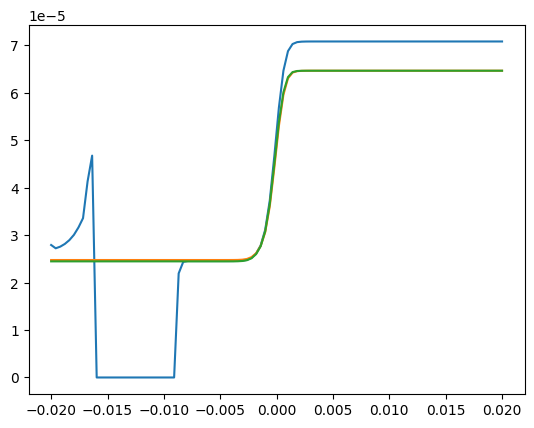

In [6]:
ch4_index = flame.gas.species_index('CH4')
o2_index = flame.gas.species_index('O2')
n2_index = flame.gas.species_index('N2')
plt.plot(flame.grid.x, flame.D[ch4_index, :], label='CH4')
plt.plot(flame.grid.x, flame.D[o2_index, :], label='O2')
plt.plot(flame.grid.x, flame.D[n2_index, :], label='N2')

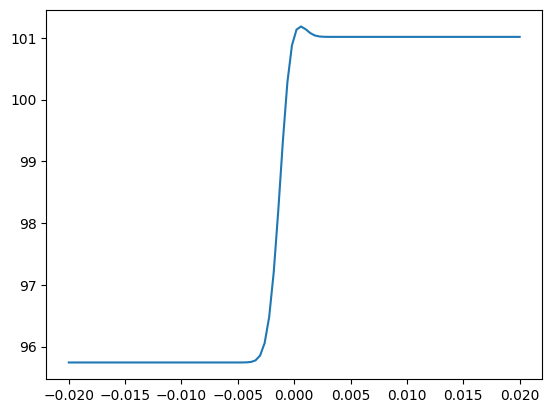

In [7]:
plt.plot(flame.grid.x, flame.U)

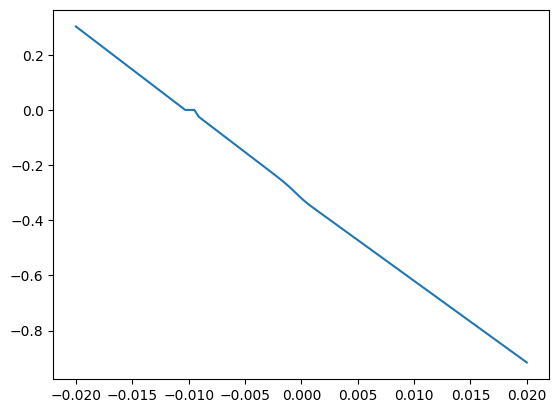

In [9]:
plt.plot(flame.grid.x, flame.V)

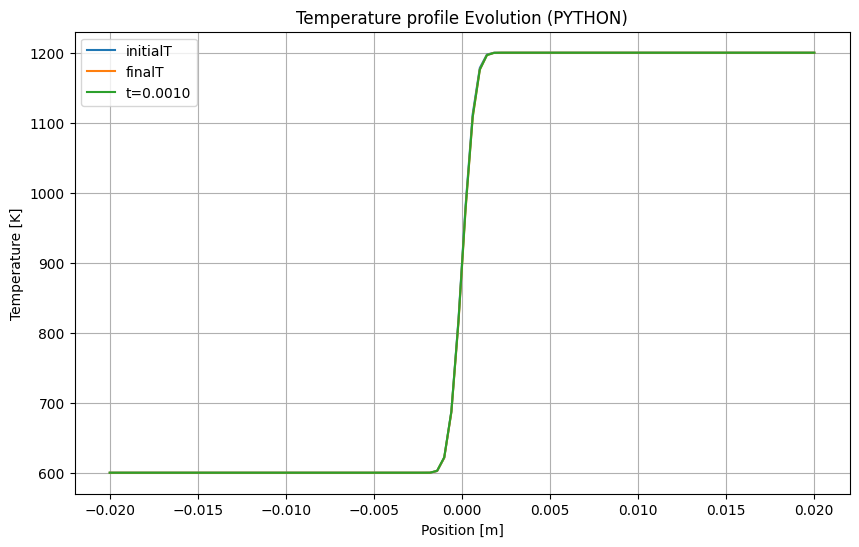

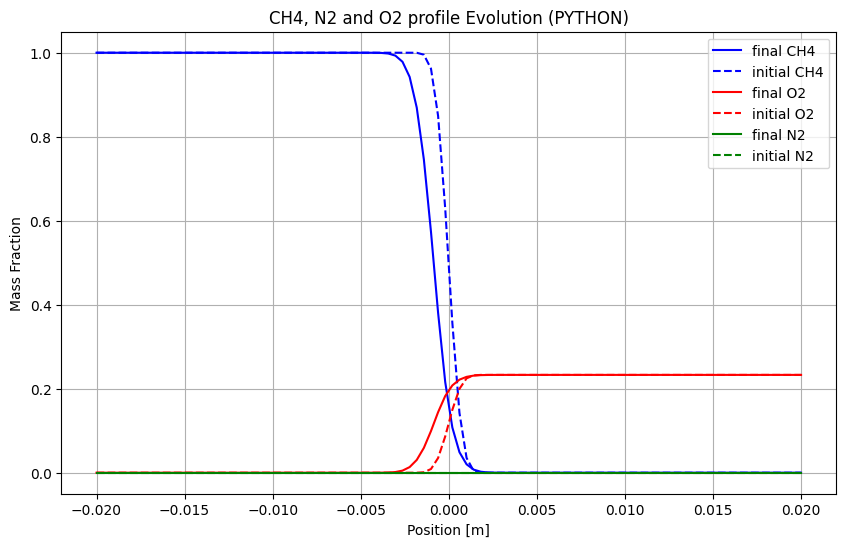

In [17]:




# Plot results
import matplotlib.pyplot as plt

# Temperature evolution
plt.figure(figsize=(10,6))

plt.plot(x_history[0], T_history[0], label=f'initialT' )
plt.plot(x_history[-1], T_history[-1], label=f'finalT' )
plt.plot(flame.grid.x, flame.convection.utw_system.T, label=f't={flame.t:.4f}')
plt.xlabel('Position [m]')
plt.ylabel('Temperature [K]')
plt.title('Temperature profile Evolution (PYTHON)')
plt.legend()
plt.grid(True)
plt.show()

# Species evolution
plt.figure(figsize=(10,6))
plt.plot(x_history[-1], Y_history[-1][13], 'b-', label='final CH4')
plt.plot(x_history[0], Y_history[0][13], 'b--', label='initial CH4')
plt.plot(x_history[-1], Y_history[-1][3], 'r-', label='final O2') 
plt.plot(x_history[0], Y_history[0][3], 'r--', label='initial O2')
plt.plot(x_history[-1], Y_history[-1][2], 'g-', label='final N2')
plt.plot(x_history[0], Y_history[0][2], 'g--', label='initial N2')
plt.xlabel('Position [m]')
plt.ylabel('Mass Fraction')
plt.title('CH4, N2 and O2 profile Evolution (PYTHON)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
flame.convection.T

array([ 600.        ,  600.        ,  600.        ,  600.        ,
        600.        ,  600.        ,  600.        ,  600.        ,
        600.        ,  600.        ,  600.        ,  600.        ,
        600.        ,  600.        ,  600.        ,  600.        ,
        600.        ,  600.        ,  600.        ,  600.        ,
        600.        ,  600.        ,  600.        ,  600.        ,
        600.        ,  600.        ,  600.        ,  600.        ,
        600.        ,  600.        ,  600.        ,  600.        ,
        600.        ,  600.        ,  600.        ,  600.        ,
        600.        ,  600.        ,  600.        ,  600.        ,
        600.        ,  600.00000001,  600.0000003 ,  600.000015  ,
        600.00077594,  600.04231695,  602.56122761,  621.37247933,
        685.96036195,  814.51109353,  976.14155922, 1107.82587978,
       1175.85759085, 1196.62694434, 1199.82601786, 1199.99105298,
       1199.99954046, 1199.99997639, 1199.99999878, 1199.99999